# Try to recover performance on unlearned task adversarially

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('acdcpp/Automatic-Circuit-Discovery/')
sys.path.append('acdcpp/')
from acdc import TLACDCExperiment
from acdcpp.ACDCPPExperiment import ACDCPPExperiment

import os
import sys
import re

# import acdc
from acdc.TLACDCExperiment import TLACDCExperiment
from acdc.acdc_utils import TorchIndex, EdgeType
import numpy as np
import torch as t
from torch import Tensor
import einops
import itertools

from transformer_lens import HookedTransformer, ActivationCache

from tqdm import tqdm
import plotly
from rich import print as rprint
from rich.table import Table

from jaxtyping import Float, Bool
from typing import Callable, Tuple, Union, Dict, Optional

import torch
import pickle

device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')
print(f'Device: {device}')

Device: cuda


## First, load model back in

In [2]:
task_type = "induction"
edge_masks = True
use_uniform = False
ioi_uniform_type = "IO_S"
weight_masks_attn = False
weight_masks_mlp = False
train_base_weights = False
localize_acdcpp = True

run_name = f"{task_type}/{use_uniform=}_"
if use_uniform:
    run_name += f"_{ioi_uniform_type=}_"
run_name += f"{edge_masks=}_{weight_masks_attn=}_{weight_masks_mlp=}_{train_base_weights=}_{localize_acdcpp=}"

epoch = 200
# want to open masks/{run_name}/mask_params_epoch=200.pt
mask_params_path = f'masks/{run_name}/ckpts/mask_params_epoch={epoch}.pth'
mask_params = torch.load(mask_params_path, map_location=device)

In [3]:
from cb_utils.models import load_demo_gpt2, tokenizer
model = load_demo_gpt2(means=False, edge_masks=edge_masks, weight_masks_attn=weight_masks_attn, weight_masks_mlp=weight_masks_mlp, train_base_weights=train_base_weights)
from tasks import IOITask, InductionTask
# task = IOITask(batch_size=16, tokenizer=tokenizer, device=device)
task = InductionTask(batch_size=16, tokenizer=tokenizer, device=device)
print(task.get_test_accuracy(model))

Using device: cuda:0
OpenAI API key not found, will not be able to run evaluations on HPSAQ Task
OpenAI API key not found, will not be able to run evaluations on HPSAQ Task
0.9375


In [4]:
from tasks import IOITask, InductionTask
# task = IOITask(batch_size=16, tokenizer=tokenizer, device=device)
task = InductionTask(batch_size=64, tokenizer=tokenizer, device=device)
print(task.get_test_accuracy(model))

0.984375


### Load unlearned model

In [5]:
# load mask params into model
# for k, v in model.named_parameters():
#     if v.requires_grad:
#         mask = mask_params.pop(0)
#         v.data = mask
model.load_state_dict(mask_params, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['output_mask_baseline', 'output_mask_frozen', 'blocks.0.edge_mask_attentions_baseline', 'blocks.0.edge_mask_attentions_frozen', 'blocks.0.edge_mask_mlp_baseline', 'blocks.0.edge_mask_mlp_frozen', 'blocks.1.edge_mask_attentions_baseline', 'blocks.1.edge_mask_attentions_frozen', 'blocks.1.edge_mask_mlp_baseline', 'blocks.1.edge_mask_mlp_frozen', 'blocks.2.edge_mask_attentions_baseline', 'blocks.2.edge_mask_attentions_frozen', 'blocks.2.edge_mask_mlp_baseline', 'blocks.2.edge_mask_mlp_frozen', 'blocks.3.edge_mask_attentions_baseline', 'blocks.3.edge_mask_attentions_frozen', 'blocks.3.edge_mask_mlp_baseline', 'blocks.3.edge_mask_mlp_frozen', 'blocks.4.edge_mask_attentions_baseline', 'blocks.4.edge_mask_attentions_frozen', 'blocks.4.edge_mask_mlp_baseline', 'blocks.4.edge_mask_mlp_frozen', 'blocks.5.edge_mask_attentions_baseline', 'blocks.5.edge_mask_attentions_frozen', 'blocks.5.edge_mask_mlp_baseline', 'blocks.5.edge_mask_mlp_frozen', 'b

In [6]:
print(task.get_test_accuracy(model))

0.65625


## Adversarial Retraining

In [8]:
# try finetuning model (finetune only weights), for now only finetune the attention and mlps
from torch.optim import AdamW
from cb_utils.learn_mask import train_masks

for name, param in model.named_parameters():
    if "attn.W_Q" in name or "attn.W_K" in name or "attn.W_V" in name or "attn.W_O" in name or "mlp.W_in" in name or "mlp.W_out" in name:
        param.requires_grad = True
    elif "attn.b_Q" in name or "attn.b_K" in name or "attn.b_V" in name or "attn.b_O" in name or "mlp.b_in" in name or "mlp.b_out" in name:
        param.requires_grad = True
    else:
        # param.requires_grad = False
        param.requires_grad = True

In [9]:
# make param_names, mask_params
param_names = [n for n, p in model.named_parameters() if p.requires_grad]
mask_params = [p for n, p in model.named_parameters() if p.requires_grad]

lr = 1e-2
weight_decay = .1
optimizer = torch.optim.AdamW(mask_params, lr=lr, weight_decay=weight_decay)

In [15]:
model.blocks[1].edge_mask_attentions

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.]], device='cuda:0')

In [30]:
task

In [10]:
from tasks import IOITask, InductionTask, OWTTask
owt_task = OWTTask(batch_size=16, tokenizer=tokenizer, device=device)
# train_tasks = {"ioi": task, "owt": owt_task}
# task_weights = {"ioi": 1.0, "owt": 1.0}
train_tasks = {task_type: task}
task_weights = {task_type: 1.0}
# eval_tasks = {"ioi": task}
ioi_task = IOITask(batch_size=16, tokenizer=tokenizer, device=device)
induction_task = InductionTask(batch_size=16, tokenizer=tokenizer, device=device)
eval_tasks = {"ioi": ioi_task, "induction": induction_task, "owt": owt_task}

train_losses, test_losses = train_masks(
    model,
    optimizer=optimizer,
    tasks=train_tasks,
    task_weights=task_weights,
    eval_tasks=eval_tasks,
    num_epochs=100,
    param_names=param_names,
    mask_params=mask_params,
    steps_per_epoch=10,
    evaluate_every=2,
    num_eval_steps=10,
    discretize_every=None,
    save_every=None,
)

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
100%|██████████| 101/101 [11:31<00:00,  6.85s/it]


In [11]:
train_losses.keys()

dict_keys(['induction', 'total'])

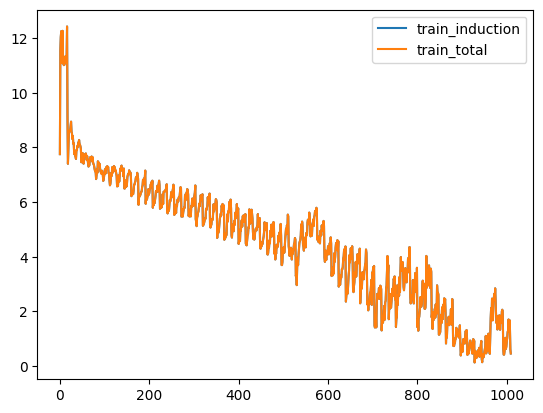

In [12]:
# plot train_losses, test_losses
import matplotlib.pyplot as plt

for k, v in train_losses.items():
    plt.plot([x[2] for x in v], label=f"train_{k}")
plt.legend()
plt.show()


In [17]:
task.get_test_accuracy(model, check_all_logits=True)

tensor(0., device='cuda:0')

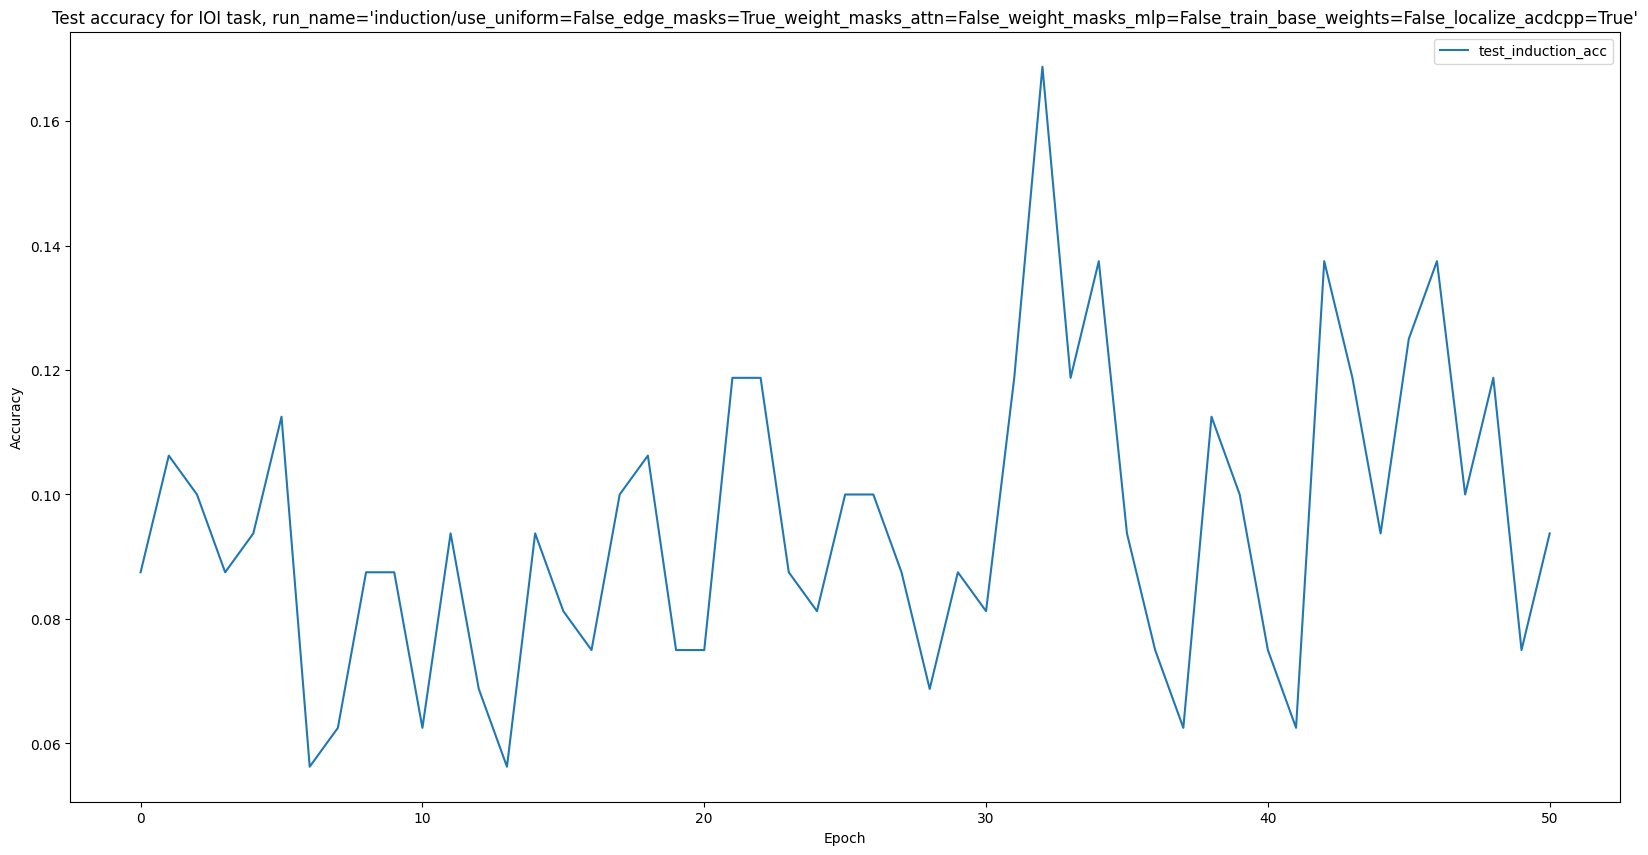

In [13]:
# plt.plot([x.item() for x in test_losses["ioi"]], label="test_ioi_loss")
# plot make figure size
plt.figure(figsize=(20, 10))
plt.title(f"Test accuracy for IOI task, {run_name=}")
plt.plot([x for x in test_losses["induction_acc"]], label="test_induction_acc")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [33]:
total_edges_masked = 0
for layer in model.blocks:
    total_edges_masked += (layer.edge_mask_attentions == 0).sum().item()
    total_edges_masked += (layer.edge_mask_attentions == 0).sum().item()
total_edges_masked

12

In [14]:
model.output_mask

Parameter containing:
tensor([1.0000e+00, 1.5650e-01, 5.9523e-01, 0.0000e+00, 1.0725e-01, 8.7802e-01,
        8.2823e-01, 3.5297e-02, 7.8490e-01, 2.8388e-01, 9.4225e-01, 1.0000e+00,
        5.0332e-01, 7.9255e-04, 1.8394e-01, 1.0514e-01, 7.9590e-02, 1.0238e-01,
        1.1676e-01, 2.8009e-01, 1.1974e-01, 1.0659e-01, 1.2278e-01, 3.4782e-01,
        4.2226e-01, 2.3647e-01, 0.0000e+00, 4.0484e-02, 0.0000e+00, 2.2432e-02,
        5.9327e-02, 2.5060e-02, 7.0497e-02, 9.4612e-03, 2.9735e-03, 2.9578e-01,
        2.6140e-02, 4.0254e-02, 2.4088e-01, 3.6391e-01, 6.5552e-02, 6.2894e-02,
        3.8981e-02, 3.0641e-02, 6.7524e-02, 3.1551e-02, 1.9095e-01, 7.8674e-02,
        1.0324e-02, 1.3126e-01, 4.2886e-02, 1.7534e-02, 3.0601e-01, 5.2917e-02,
        4.2399e-02, 3.8703e-01, 2.1859e-01, 0.0000e+00, 3.2423e-01, 1.6465e-02,
        2.7266e-02, 4.5890e-01, 0.0000e+00, 1.0145e-01, 0.0000e+00, 1.9689e-01,
        4.8113e-02, 1.8202e-01, 1.3127e-02, 1.5502e-03, 4.2302e-02, 4.9983e-04,
        0.0000e+00

In [25]:
print((model.blocks[1].edge_mask_attentions == 0).sum())

tensor(4, device='cuda:0')


In [ ]:
model.blocks[11].edge_mask_attentions

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

output_mask True
embed.W_E False
pos_embed.W_pos False
ln_final.w False
ln_final.b False
unembed.W_U False
unembed.b_U False
blocks.0.edge_mask_attentions True
blocks.0.edge_mask_mlp True
blocks.0.ln1.w False
blocks.0.ln1.b False
blocks.0.attn.W_Q False
blocks.0.attn.b_Q False
blocks.0.attn.W_K False
blocks.0.attn.b_K False
blocks.0.attn.W_V False
blocks.0.attn.b_V False
blocks.0.attn.W_O False
blocks.0.attn.b_O False
blocks.0.ln2.w False
blocks.0.ln2.b False
blocks.0.mlp.W_in False
blocks.0.mlp.b_in False
blocks.0.mlp.W_out False
blocks.0.mlp.b_out False
blocks.1.edge_mask_attentions True
blocks.1.edge_mask_mlp True
blocks.1.ln1.w False
blocks.1.ln1.b False
blocks.1.attn.W_Q False
blocks.1.attn.b_Q False
blocks.1.attn.W_K False
blocks.1.attn.b_K False
blocks.1.attn.W_V False
blocks.1.attn.b_V False
blocks.1.attn.W_O False
blocks.1.attn.b_O False
blocks.1.ln2.w False
blocks.1.ln2.b False
blocks.1.mlp.W_in False
blocks.1.mlp.b_in False
blocks.1.mlp.W_out False
blocks.1.mlp.b_out False
b

## Extraction Attacks
from https://arxiv.org/pdf/2309.17410.pdf

In [7]:
# logit lens: decode residual stream
from fancy_einsum import einsum

from collections import defaultdict
def layer_hook_function(layer, outputs):
    def hook_fn(module, input, output):
      outputs[layer].append(output.clone().detach())
      return output
    return hook_fn

def get_residuals(batch_text, model, input_text=True):
    outputs = defaultdict(list)
    hooks = []
    for layer, block in enumerate(model.blocks):
        hook_fn = layer_hook_function(layer, outputs=outputs)
        hook_applied = block.register_forward_hook(hook_fn)
        hooks.append(hook_applied)

    for prompt in batch_text:
        if input_text:
            tokenized = tokenizer(prompt, return_tensors="pt").input_ids
            model(tokenized)
            # print(tokenized.shape)
        else:
            tokenized = prompt
        # tokenized = tokenizer(prompt, return_tensors="pt").input_ids
            with torch.no_grad():
                model(tokenized)
    
    for hook in hooks:
        hook.remove()
    
    return outputs

def get_logits(model, residual):
    num_components = residual.shape[-2]
    masked_resid = einsum("batch position prev_head_idx d_model, prev_head_idx -> batch position d_model", residual, model.output_mask[:num_components])
    normalized_resid = model.ln_final(masked_resid)
    logits = model.unembed(normalized_resid)
    return logits

## IOI

In [6]:
task = IOITask(batch_size=64, tokenizer=tokenizer, device=device)
batch = task.get_batch()
outputs = get_residuals(batch['text'], model)

In [7]:
len(outputs[0])

64

In [8]:
decode_layer = 9
logits = get_logits(model, outputs[decode_layer][0])[0, -1]
# print(batch['text'][0])
print(f"Decoding at layer {decode_layer}, token: {logits.argmax(-1)}, name: {tokenizer.decode(logits.argmax(-1))}")

Decoding at layer 9, token: 12806, name:  Jacob


In [9]:
import torch.nn.functional as F
import pandas as pd

n_layers = 12

# Initialize an empty DataFrame with MultiIndex
# columns = pd.MultiIndex.from_product([range(n_layers), ['io_logprob', 's_logprob', 'io_pos']], names=['Layer', 'Metric'])
columns = pd.MultiIndex.from_product([range(n_layers), ['io_logprob', 's_logprob', 'io_pos']], names=['Layer', 'Metric'])
df = pd.DataFrame(columns=columns)

for point_idx in range(len(outputs[0])):
    io_token = tokenizer(" "+batch['IO'][point_idx])['input_ids'][-1]
    s_token = tokenizer(" "+batch['S'][point_idx])['input_ids'][-1]
    print(f"IO token: {io_token}, S token: {s_token}")
    data = {}  # This will hold the data for this point_idx
    for decode_layer in range(n_layers):
        with torch.no_grad():
            logits = get_logits(model, outputs[decode_layer][point_idx])[0, -1]
            logprobs = F.softmax(logits, dim=-1).log()
            io_logprob = logprobs[io_token].item()
            s_logprob = logprobs[s_token].item()
            io_s_logit_diff = (logits[io_token] - logits[s_token]).item()
            # Add the metrics to the data dictionary
            data[(decode_layer, 'io_logprob')] = io_logprob
            data[(decode_layer, 's_logprob')] = s_logprob
            
            # if io_logprob is the nth highest, store n
            io_pos = (logprobs >= io_logprob).sum().item()
            data[(decode_layer, 'io_pos')] = io_pos

    # Add the data for this point_idx to the DataFrame
    # df = df.append(pd.Series(data, name=point_idx))
    df.loc[point_idx] = pd.Series(data, name=point_idx)

# Now df holds the data for all point_idx and layers
display(df)

IO token: 12806, S token: 10805
IO token: 8403, S token: 10674
IO token: 9953, S token: 18501
IO token: 17652, S token: 7212
IO token: 11735, S token: 8049
IO token: 3977, S token: 8616
IO token: 2940, S token: 11328
IO token: 8616, S token: 12181
IO token: 7993, S token: 11735
IO token: 5866, S token: 12313
IO token: 8078, S token: 11526
IO token: 27599, S token: 3700
IO token: 10443, S token: 7859
IO token: 16556, S token: 10490
IO token: 12969, S token: 14235
IO token: 7970, S token: 8982
IO token: 11232, S token: 7939
IO token: 9918, S token: 1757
IO token: 5658, S token: 11288
IO token: 8049, S token: 5866
IO token: 5613, S token: 5278
IO token: 10592, S token: 9077
IO token: 14909, S token: 7806
IO token: 8982, S token: 7993
IO token: 12091, S token: 14235
IO token: 10888, S token: 10443
IO token: 10888, S token: 16753
IO token: 16738, S token: 12803
IO token: 11328, S token: 10490
IO token: 11328, S token: 16738
IO token: 3977, S token: 7970
IO token: 7212, S token: 27599
IO tok

Layer          0                              1                       \
Metric io_logprob  s_logprob   io_pos io_logprob  s_logprob   io_pos   
0      -14.425510 -15.744898   5874.0 -14.851326 -16.770042   4407.0   
1      -14.477891 -15.581673   6295.0 -15.492310 -16.311127   6378.0   
2      -18.011404 -16.274372  23588.0 -18.324383 -17.335897  19118.0   
3      -15.866784 -16.276558   9749.0 -16.165226 -16.311728   7520.0   
4      -15.377517 -13.138150   7875.0 -15.722683 -13.778467   6168.0   
..            ...        ...      ...        ...        ...      ...   
59     -16.298180 -12.072758  14217.0 -17.122234 -12.648518  11987.0   
60     -14.230032 -14.701427   4563.0 -14.780943 -15.333654   4181.0   
61     -15.522944 -13.468596   8746.0 -16.817539 -14.052258  10433.0   
62     -17.908405 -15.652658  23438.0 -18.480042 -15.931018  19243.0   
63     -15.807187 -14.865491  10755.0 -16.970070 -15.638687  10108.0   

Layer          2                              3   ...       8          9   \
Metric io_logprob  s_logprob   io_pos io_logprob  ...   io_pos io_logprob   
0      -14.881495 -17.121620   5325.0 -15.559320  ...    264.0  -0.000668   
1      -15.304857 -15.815471   6300.0 -16.739988  ...     62.0  -0.000105   
2      -17.208567 -17.024078  13059.0 -18.247515  ...    126.0  -0.000871   
3      -14.978770 -15.164392   4955.0 -15.419357  ...  10141.0  -5.868086   
4      -16.180933 -13.044759   8163.0 -15.280287  ...    166.0  -1.356447   
..            ...        ...      ...        ...  ...      ...        ...   
59     -16.816360 -11.245339  13078.0 -16.782442  ...   2598.0  -0.025724   
60     -12.725886 -15.883439   1755.0 -13.195567  ...    364.0  -0.025735   
61     -17.024090 -14.808061  10999.0 -16.401188  ...     15.0  -0.020875   
62     -16.567589 -14.773880  11528.0 -15.564317  ...    237.0  -0.009351   
63     -15.685458 -14.693156   6282.0 -14.871096  ...    104.0  -0.009112   

Layer                            10                           11            \
Metric  s_logprob io_pos io_logprob  s_logprob io_pos io_logprob s_logprob   
0      -18.093712    1.0  -0.000355 -15.379760    1.0  -0.132035 -5.910069   
1      -15.921527    1.0  -0.000109 -11.288273    1.0  -0.254606 -4.362401   
2      -15.530816    1.0  -0.000836 -13.466070    1.0  -0.676929 -6.024078   
3       -1.310925   23.0  -0.872646  -1.470192    1.0  -1.717130 -2.253018   
4       -7.163959    2.0  -0.465709  -4.785045    1.0  -1.595379 -3.179348   
..            ...    ...        ...        ...    ...        ...       ...   
59     -10.445360    1.0  -0.003586  -9.281754    1.0  -0.283385 -4.987830   
60      -9.835147    1.0  -0.013566 -10.410718    1.0  -0.679431 -5.812931   
61     -10.608553    1.0  -0.006965  -7.782367    1.0  -0.576956 -3.136961   
62     -12.060126    1.0  -0.004114  -8.991064    1.0  -0.515924 -3.623224   
63      -7.776084    1.0  -0.012758  -4.979799    1.0  -0.798677 -2.864748   

Layer          
Metric io_pos  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0  
..        ...  
59        1.0  
60        1.0  
61        1.0  
62        1.0  
63        1.0  

[64 rows x 36 columns]

### Attack 1: plot ave prob of IO token against layer

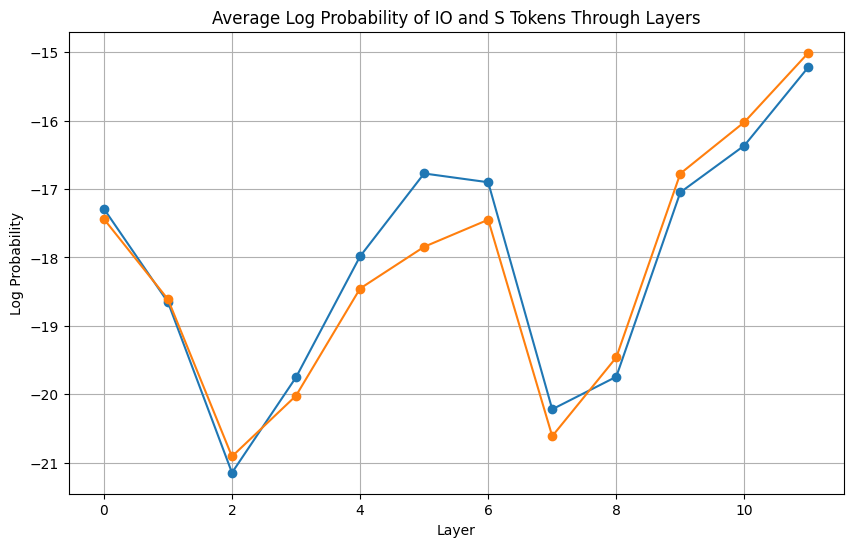

In [10]:
import matplotlib.pyplot as plt

use_logprob = True

# Calculate the average log-probability of the IO token for each layer
if use_logprob:
    avg_io_prob = df.xs('io_logprob', level='Metric', axis=1).mean()
    avg_s_prob = df.xs('s_logprob', level='Metric', axis=1).mean()
else:
    # take exp of logprobs
    avg_io_prob = df.xs('io_logprob', level='Metric', axis=1).apply(np.exp).mean()
    avg_s_prob = df.xs('s_logprob', level='Metric', axis=1).apply(np.exp).mean()
    
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(avg_io_prob.index, avg_io_prob.values, marker='o', label='IO')
plt.plot(avg_s_prob.index, avg_s_prob.values, marker='o', label='S')
plt.xlabel('Layer')
if use_logprob:
    plt.ylabel('Log Probability')
    plt.title('Average Log Probability of IO and S Tokens Through Layers')
else:
    plt.ylabel('Probability')
    plt.title('Average Probability of IO and S Tokens Through Layers')
plt.grid(True)
plt.show()

### Attack 2: plot average or median position of IO token against layer
This tells you approximately what top-"k" you need to find the IO token in the correct layer

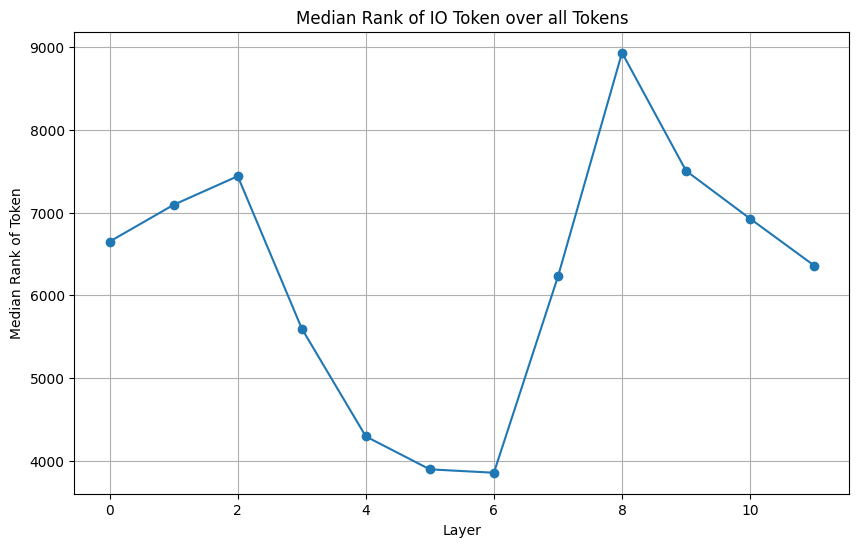

In [11]:
# Plot median position of IO token against layer

# Calculate the median position of the IO token for each layer
median_io_pos = df.xs('io_pos', level='Metric', axis=1).median()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(median_io_pos.index, median_io_pos.values, marker='o')
plt.xlabel('Layer')
plt.ylabel('Median Rank of Token')
plt.title('Median Rank of IO Token over all Tokens')
plt.grid(True)
plt.show()

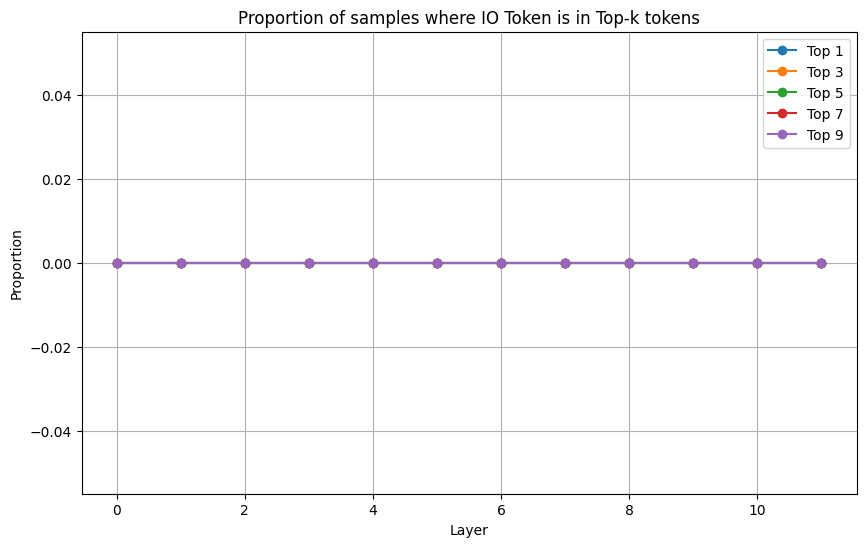

In [12]:
# Given top-k, what proportion of the time is the IO token in the top-k?

def get_top_k_accuracy(df, k):
    # Calculate the proportion of the time the IO token is in the top-k
    top_k = df.xs('io_pos', level='Metric', axis=1) <= k
    top_k_accuracy = top_k.mean()
    return top_k_accuracy

# Create the plot
plt.figure(figsize=(10, 6))
for k in range(1, 11, 2):
    top_k_accuracy = get_top_k_accuracy(df, k)
    plt.plot(top_k_accuracy.index, top_k_accuracy.values, marker='o', label=f'Top {k}')

plt.xlabel('Layer')
plt.ylabel('Proportion')
plt.title('Proportion of samples where IO Token is in Top-k tokens')
plt.grid(True)
plt.legend()
plt.show()

### Attack 3: Probability Delta
Deleted answer may quickly rise and fall in probability, so rank order differences in the probs of each token between successive layers

In [13]:
use_logprob = True
vocab_size = tokenizer.vocab_size
use_abs = True

# Initialize an empty DataFrame with MultiIndex for 11 layers
columns = pd.MultiIndex.from_product([range(11), ['io_diff_rank']], names=['Layer', 'Metric'])
df_diff = pd.DataFrame(columns=columns)

for point_idx in tqdm(range(len(outputs[0]))):
    io_token = tokenizer(" "+batch['IO'][point_idx])['input_ids'][-1]
    data = {}  # This will hold the data for this point_idx
    probs_tensor = torch.zeros(12, tokenizer.vocab_size)
    for decode_layer in range(12):
        with torch.no_grad():
            logits = get_logits(model, outputs[decode_layer][point_idx])[0, -1]
            logprobs = F.softmax(logits, dim=-1)
            if use_logprob:
                probs_tensor[decode_layer] = logprobs
            else:
                probs_tensor[decode_layer] = logprobs.exp()

    # probability of IO token should drop from layer n to n+1, so probs[n+1] - probs[n] should be negative, find the most negative or just abs
    if use_abs:
        diff = (probs_tensor[1:] - probs_tensor[:-1]).abs()  # shape (11, vocab_size)
    else:
        diff = probs_tensor[:-1] - probs_tensor[1:] # larger = higher drop

    # print(diff.shape)
    io_diffs = diff[:, io_token]
    for layer_diff_index in range(11):
        io_diff = io_diffs[layer_diff_index]
        io_diff_rank = (diff[layer_diff_index] >= io_diff).sum().item()
        # Add the metric to the data dictionary
        data[(layer_diff_index, 'io_diff_rank')] = io_diff_rank
    # Add the data for this point_idx to the DataFrame
    # df_diff = df_diff.append(pd.Series(data, name=point_idx))
    df_diff.loc[point_idx] = pd.Series(data, name=point_idx)

# Now df_diff holds the data for all point_idx and layers
display(df_diff)

100%|██████████| 64/64 [00:29<00:00,  2.16it/s]


Layer,0,1,2,3,4,5,6,7,8,9,10
Metric,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank,io_diff_rank
0,8035,26734,16695,10855,26291,13786,21068,14687,16564,15408,21730
1,4108,4794,2481,3937,3553,3413,3255,6439,2920,5544,1422
2,4530,9822,12768,5316,7670,5944,5118,11909,4699,5548,13273
3,2334,1075,921,1950,2711,2173,1506,4938,8901,3032,3289
4,3717,13099,7878,4391,3292,2895,3988,10857,2021,2391,4490
...,...,...,...,...,...,...,...,...,...,...,...
59,14738,12223,7976,3675,2053,2075,2390,4727,2620,1515,1221
60,19766,16944,16623,12823,11709,7831,6679,17765,13942,14120,13790
61,13765,10178,1897,3963,5994,6696,7935,4706,1239,1201,1235


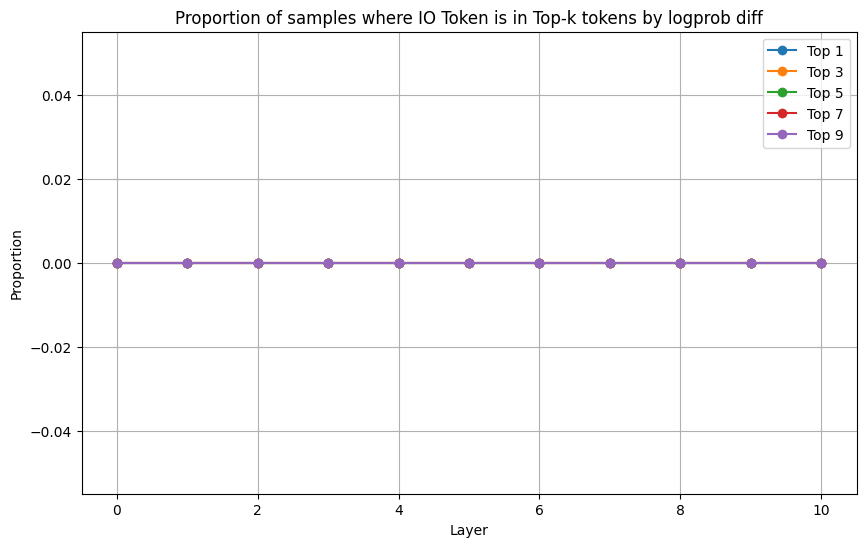

In [14]:
# Given top-k, what proportion of the time is the IO token in the top-k for df_diff?

def get_top_k_accuracy(df, k):
    # Calculate the proportion of the time the IO token is in the top-k
    top_k = df.xs('io_diff_rank', level='Metric', axis=1) <= k
    top_k_accuracy = top_k.mean()
    return top_k_accuracy

# Create the plot
plt.figure(figsize=(10, 6))
for k in range(1, 11, 2):
    top_k_accuracy = get_top_k_accuracy(df_diff, k)
    plt.plot(top_k_accuracy.index, top_k_accuracy.values, marker='o', label=f'Top {k}')


plt.xlabel('Layer')
plt.ylabel('Proportion')
plt.title('Proportion of samples where IO Token is in Top-k tokens by logprob diff')
plt.grid(True)
plt.legend()
plt.show()


### Get attack performances
As per the paper, get the proportion of times the IO token is in the candidate set, with the candidate set being constructed from either topk logprobs or topk diffs. As input, use L (which layers to analyze) and k, with a bound of |L|*k <= B (budget).

In [ ]:
# budget = 20
# lk_combos = [(1, 20), (2, 10), (4, 5), (5, 4), (10, 2)] # first number is num layers to look at, second number is num tokens to look at

# check all layers, check top 10 tokens


## Induction

In [8]:
# task = IOITask(batch_size=64, tokenizer=tokenizer, device=device)
task = InductionTask(batch_size=64, tokenizer=tokenizer, device=device)
batch = task.get_batch()
outputs = get_residuals(batch[:,:-1].unsqueeze(1), model, input_text=False)

In [9]:
import torch.nn.functional as F
import pandas as pd

n_layers = 12

# Initialize an empty DataFrame with MultiIndex
# columns = pd.MultiIndex.from_product([range(n_layers), ['io_logprob', 's_logprob', 'io_pos']], names=['Layer', 'Metric'])
columns = pd.MultiIndex.from_product([range(n_layers), ['correct_logprob', 'logprob_rank']], names=['Layer', 'Metric'])
df = pd.DataFrame(columns=columns)

for point_idx in range(len(outputs[0])):
    # io_token = tokenizer(" "+batch['IO'][point_idx])['input_ids'][-1]
    correct_token = batch[point_idx, -1]
    # s_token = tokenizer(" "+batch['S'][point_idx])['input_ids'][-1]
    # print(f"IO token: {io_token}, S token: {s_token}")
    print(correct_token)

    data = {}  # This will hold the data for this point_idx
    for decode_layer in range(n_layers):
        with torch.no_grad():
            logits = get_logits(model, outputs[decode_layer][point_idx])[0, -1]
            logprobs = F.softmax(logits, dim=-1).log()
            correct_logprob = logprobs[correct_token].item()
            # Add the metrics to the data dictionary
            data[(decode_layer, 'correct_logprob')] = correct_logprob
            
            # if io_logprob is the nth highest, store n
            logprob_pos = (logprobs >= correct_logprob).sum().item()
            data[(decode_layer, 'logprob_rank')] = logprob_pos

    # Add the data for this point_idx to the DataFrame
    # df = df.append(pd.Series(data, name=point_idx))
    df.loc[point_idx] = pd.Series(data, name=point_idx)

# Now df holds the data for all point_idx and layers
display(df)

tensor(44927)
tensor(36002)
tensor(23406)
tensor(17394)
tensor(48560)
tensor(540)
tensor(10344)
tensor(40555)
tensor(22606)
tensor(19443)
tensor(14404)
tensor(22685)
tensor(37931)
tensor(44067)
tensor(5128)
tensor(33382)
tensor(45573)
tensor(27602)
tensor(30745)
tensor(38237)
tensor(14573)
tensor(16886)
tensor(14492)
tensor(18529)
tensor(28535)
tensor(20069)
tensor(7601)
tensor(28560)
tensor(42095)
tensor(34539)
tensor(47354)
tensor(10908)
tensor(34073)
tensor(41107)
tensor(19152)
tensor(17276)
tensor(36604)
tensor(42254)
tensor(7953)
tensor(5295)
tensor(42163)
tensor(18040)
tensor(1981)
tensor(2898)
tensor(36062)
tensor(16873)
tensor(1965)
tensor(1144)
tensor(12943)
tensor(13944)
tensor(37585)
tensor(25344)
tensor(28639)
tensor(44832)
tensor(4494)
tensor(46994)
tensor(10316)
tensor(23013)
tensor(33719)
tensor(25410)
tensor(17208)
tensor(47234)
tensor(1877)
tensor(14200)


Layer               0                            1                \
Metric correct_logprob logprob_rank correct_logprob logprob_rank   
0           -17.992506      17475.0      -17.675592      15260.0   
1           -20.028202      36700.0      -17.371454      32370.0   
2           -28.721617      45039.0      -25.834965      44108.0   
3           -26.191736      44006.0      -23.608170      44649.0   
4           -12.251301        615.0      -10.288815        531.0   
..                 ...          ...             ...          ...   
59          -18.093439      33562.0      -18.078178      34973.0   
60          -23.809938      33160.0      -22.167170      35364.0   
61          -18.979588      19129.0      -16.028942      15290.0   
62          -16.130550       1622.0      -13.056248        757.0   
63          -16.773272        951.0      -11.532763        631.0   

Layer               2                            3                \
Metric correct_logprob logprob_rank correct_logprob logprob_rank   
0           -15.956027       9587.0      -17.781738      16838.0   
1           -17.535088      30114.0      -19.452282      35935.0   
2           -20.878088      36624.0      -20.887747      38028.0   
3           -21.248558      40351.0      -20.308775      35865.0   
4           -12.313845       1123.0      -12.912258       1927.0   
..                 ...          ...             ...          ...   
59          -18.140255      34504.0      -19.782701      37493.0   
60          -22.582409      35036.0      -23.136410      37467.0   
61          -15.714055      12508.0      -15.901590       8031.0   
62           -9.611178        419.0       -9.800300        614.0   
63          -11.099086        956.0      -11.451715        836.0   

Layer               4                ...              7                \
Metric correct_logprob logprob_rank  ... correct_logprob logprob_rank   
0           -19.770218      17802.0  ...       -5.992593         47.0   
1           -21.573801      38363.0  ...      -18.540287      14752.0   
2           -21.254213      37685.0  ...      -17.487120       4079.0   
3           -18.669743      28843.0  ...       -8.849652        248.0   
4           -13.209615       3917.0  ...       -4.142885          9.0   
..                 ...          ...  ...             ...          ...   
59          -20.132124      38544.0  ...      -13.208444       1593.0   
60          -22.857634      32141.0  ...      -15.195263       2283.0   
61          -15.657675       5784.0  ...       -9.561091        481.0   
62          -10.026031        709.0  ...       -4.996308         17.0   
63          -10.774582        754.0  ...       -5.446840         13.0   

Layer               8                            9                \
Metric correct_logprob logprob_rank correct_logprob logprob_rank   
0            -3.380315          5.0       -0.194791          1.0   
1           -17.240309      10124.0      -12.965884       1732.0   
2           -12.694247        971.0      -11.052177        550.0   
3            -7.207863         64.0       -3.081238          7.0   
4            -2.348198          3.0       -0.096584          1.0   
..                 ...          ...             ...          ...   
59          -10.168816        319.0       -4.404068         16.0   
60          -10.660228        353.0       -7.913008         74.0   
61           -6.747589         71.0       -1.783572          2.0   
62           -2.243108          2.0       -2.971443          4.0   
63           -5.756953         11.0       -1.222260          2.0   

Layer               10                           11               
Metric correct_logprob logprob_rank correct_logprob logprob_rank  
0            -0.846008          1.0       -7.531663        182.0  
1           -15.454902       5405.0      -10.153544       4003.0  
2           -13.707730       2567.0       -9.834899       2419.0  
3            -6.411092         64.0       -7.679169        1

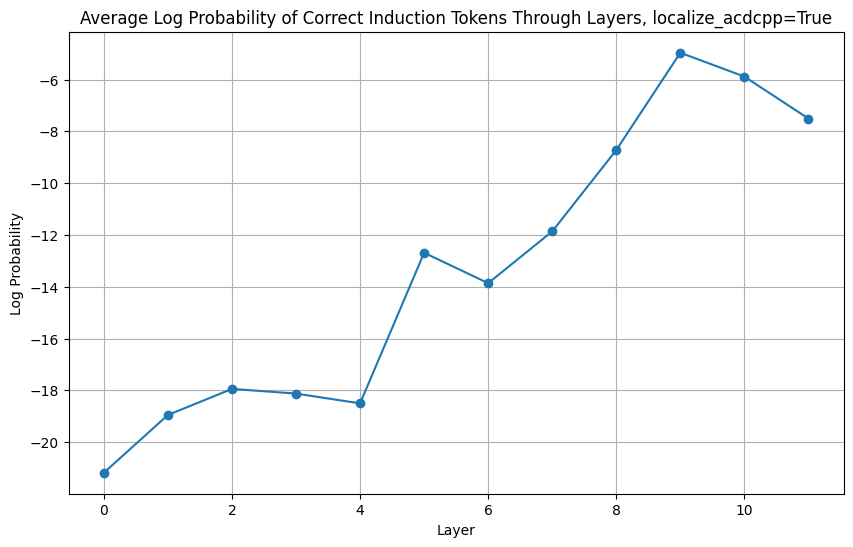

In [10]:
import matplotlib.pyplot as plt

use_logprob = True

# Calculate the average log-probability of the IO token for each layer
if use_logprob:
    avg_correct_prob = df.xs('correct_logprob', level='Metric', axis=1).mean()
    # avg_s_prob = df.xs('s_logprob', level='Metric', axis=1).mean()
else:
    # take exp of logprobs
    avg_correct_prob = df.xs('correct_logprob', level='Metric', axis=1).apply(np.exp).mean()
    # avg_s_prob = df.xs('s_logprob', level='Metric', axis=1).apply(np.exp).mean()
    
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(avg_correct_prob.index, avg_correct_prob.values, marker='o', label='IO')
# plt.plot(avg_s_prob.index, avg_s_prob.values, marker='o', label='S')
plt.xlabel('Layer')
if use_logprob:
    plt.ylabel('Log Probability')
    plt.title(f'Average Log Probability of Correct Induction Tokens Through Layers, {localize_acdcpp=}')
else:
    plt.ylabel('Probability')
    plt.title(f'Average Probability ofCorrect Induction Tokens Through Layers, {localize_acdcpp=}')
plt.grid(True)
plt.show()

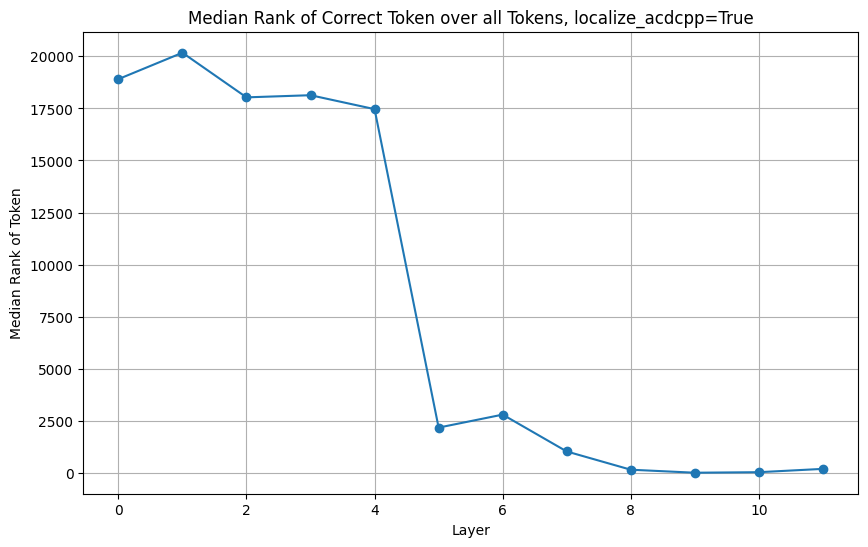

In [11]:
# Plot median position of IO token against layer

# Calculate the median position of the IO token for each layer
median_io_pos = df.xs('logprob_rank', level='Metric', axis=1).median()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(median_io_pos.index, median_io_pos.values, marker='o')
plt.xlabel('Layer')
plt.ylabel('Median Rank of Token')
plt.title(f'Median Rank of Correct Token over all Tokens, {localize_acdcpp=}')
plt.grid(True)
plt.show()